In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None, horizon=8)
df.to_pickle('/tmp/df_horizon8_price_type_none.pkl')
display(df)

op            hi           lo  \
timestamp                 symbol                                            
2019-07-20 12:00:00+00:00 BNB        30.722500     30.772500     30.62500   
                          BTC     10564.250000  10630.000000  10525.50000   
                          ETH       225.930000    226.440000    225.51000   
                          XRP         0.327975      0.328400      0.32700   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.867500     30.33500   
...                                        ...           ...          ...   
2022-11-09 12:00:00+00:00 ETH      1218.900000   1262.300000   1215.70000   
                          LINK        6.800500      6.977000      6.73900   
                          MATIC       0.940400      0.967300      0.92080   
                          SOL        18.595000     19.800000     18.06000   
                          XRP         0.375250      0.385775      0.37465   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-11-09 12:00:00+00:00 ETH      1240.100000  2.558305e+08   
                          LINK        6.818500  4.735283e+06   
                          MATIC       0.938100  1.362755e+07   
                          SOL        18.985000  5.257909e+07   
                          XRP         0.379625  8.275274e+06   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00  0.026612  
                          BTC    2019-07-20 13:00:00+00:00  0.034090  
                          ETH    2019-07-20 13:00:00+00:00  0.030901  
                          XRP    2019-07-20 13:00:00+00:00  0.037908  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00  0.026836  
...                                                    ...       ...  
2022-11-09 12:00:00+00:00 ETH    2022-11-09 13:00:00+00:00       NaN  
                          LINK   2022-11-09 13:00:00+00:00       NaN  
                          MATIC  2022-11-09 13:00:00+00:00       NaN  
                          SOL    2022-11-09 13:00:00+00:00       NaN  
                          XRP    2022-11-09 13:00:00+00:00       NaN  

[262038 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-11-09 13:36:57.903774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 13:36:58.226543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 13:36:58.226626: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-09 13:36:58.288853: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 13:37:00.410132: W tensorflow/stream_executor/platform/de

In [5]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [6]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [7]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [8]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [9]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [10]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble
        self.horizon = 8

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 1 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

float32
fit df.shape (201190, 39)


2022-11-09 13:37:25.595266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-09 13:37:25.595329: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 13:37:25.595359: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f2e5dfb506bd): /proc/driver/nvidia/version does not exist
2022-11-09 13:37:25.595682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: /tmp/tmpdkpe9yyz/assets


INFO:tensorflow:Assets written to: /tmp/tmpdkpe9yyz/assets
2022-11-09 13:42:33.040396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:33.040485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:33.041414: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdkpe9yyz
2022-11-09 13:42:33.043573: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:33.043613: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdkpe9yyz
2022-11-09 13:42:33.052807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-09 13:42:33.054674: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:33.113459: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpvx57ke9d/assets


INFO:tensorflow:Assets written to: /tmp/tmpvx57ke9d/assets
2022-11-09 13:42:34.961932: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:34.962022: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:34.962219: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvx57ke9d
2022-11-09 13:42:34.964953: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:34.964997: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvx57ke9d
2022-11-09 13:42:34.981561: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:35.045168: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvx57ke9d
2022-11-09 13:42:35.061198: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph3fbc0io/assets


INFO:tensorflow:Assets written to: /tmp/tmph3fbc0io/assets
2022-11-09 13:42:37.603101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:37.603192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:37.603411: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph3fbc0io
2022-11-09 13:42:37.608190: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:37.608278: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph3fbc0io
2022-11-09 13:42:37.624698: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:37.703375: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph3fbc0io
2022-11-09 13:42:37.726132: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0xyytgzl/assets


INFO:tensorflow:Assets written to: /tmp/tmp0xyytgzl/assets
2022-11-09 13:42:39.618620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:39.618709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:39.618903: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0xyytgzl
2022-11-09 13:42:39.621326: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:39.621370: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0xyytgzl
2022-11-09 13:42:39.628787: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:39.689458: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0xyytgzl
2022-11-09 13:42:39.705366: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjeg9ere6/assets


INFO:tensorflow:Assets written to: /tmp/tmpjeg9ere6/assets
2022-11-09 13:42:41.483785: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:41.483877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:41.484072: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjeg9ere6
2022-11-09 13:42:41.486234: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:41.486276: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjeg9ere6
2022-11-09 13:42:41.493266: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:41.553715: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjeg9ere6
2022-11-09 13:42:41.569191: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphko__4cs/assets


INFO:tensorflow:Assets written to: /tmp/tmphko__4cs/assets
2022-11-09 13:42:43.341081: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:43.341175: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:43.341372: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphko__4cs
2022-11-09 13:42:43.343497: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:43.343538: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphko__4cs
2022-11-09 13:42:43.350486: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:43.409578: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphko__4cs
2022-11-09 13:42:43.424558: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5kc7i7kb/assets


INFO:tensorflow:Assets written to: /tmp/tmp5kc7i7kb/assets
2022-11-09 13:42:45.484107: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:45.484231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:45.484614: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5kc7i7kb
2022-11-09 13:42:45.487258: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:45.487309: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5kc7i7kb
2022-11-09 13:42:45.495926: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:45.566879: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5kc7i7kb
2022-11-09 13:42:45.586304: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcb_t8exs/assets


INFO:tensorflow:Assets written to: /tmp/tmpcb_t8exs/assets
2022-11-09 13:42:47.417783: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:47.417882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:47.418079: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcb_t8exs
2022-11-09 13:42:47.420233: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:47.420276: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcb_t8exs
2022-11-09 13:42:47.427199: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:47.486623: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcb_t8exs
2022-11-09 13:42:47.502613: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3z2wte7p/assets


INFO:tensorflow:Assets written to: /tmp/tmp3z2wte7p/assets
2022-11-09 13:42:49.267613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:49.267703: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:49.267899: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3z2wte7p
2022-11-09 13:42:49.270065: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:49.270108: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3z2wte7p
2022-11-09 13:42:49.277278: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:49.336503: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3z2wte7p
2022-11-09 13:42:49.352077: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2fd1m07z/assets


INFO:tensorflow:Assets written to: /tmp/tmp2fd1m07z/assets
2022-11-09 13:42:51.129609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:42:51.129684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:42:51.129877: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2fd1m07z
2022-11-09 13:42:51.131985: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:42:51.132027: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2fd1m07z
2022-11-09 13:42:51.139066: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:42:51.198231: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2fd1m07z
2022-11-09 13:42:51.213552: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

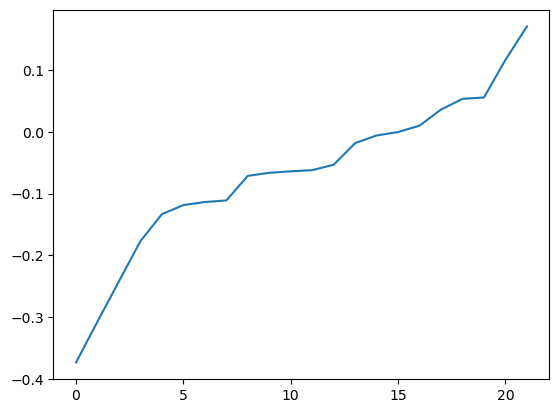

fit df.shape (186931, 39)


INFO:tensorflow:Assets written to: /tmp/tmpzyx2tfyc/assets


INFO:tensorflow:Assets written to: /tmp/tmpzyx2tfyc/assets
2022-11-09 13:49:26.174059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:26.174154: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:26.174356: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzyx2tfyc
2022-11-09 13:49:26.176501: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:26.176554: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzyx2tfyc
2022-11-09 13:49:26.183414: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:26.241801: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzyx2tfyc
2022-11-09 13:49:26.257605: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjmo2nb6w/assets


INFO:tensorflow:Assets written to: /tmp/tmpjmo2nb6w/assets
2022-11-09 13:49:28.062357: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:28.062456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:28.062663: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjmo2nb6w
2022-11-09 13:49:28.064834: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:28.064878: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjmo2nb6w
2022-11-09 13:49:28.072279: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:28.133743: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjmo2nb6w
2022-11-09 13:49:28.149714: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbfysc3oq/assets


INFO:tensorflow:Assets written to: /tmp/tmpbfysc3oq/assets
2022-11-09 13:49:29.892413: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:29.892514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:29.892713: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbfysc3oq
2022-11-09 13:49:29.894878: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:29.894929: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbfysc3oq
2022-11-09 13:49:29.902141: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:29.959950: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbfysc3oq
2022-11-09 13:49:29.974936: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppf5cnwdw/assets


INFO:tensorflow:Assets written to: /tmp/tmppf5cnwdw/assets
2022-11-09 13:49:31.728610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:31.728699: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:31.728893: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppf5cnwdw
2022-11-09 13:49:31.731020: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:31.731064: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppf5cnwdw
2022-11-09 13:49:31.738155: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:31.796543: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppf5cnwdw
2022-11-09 13:49:31.811637: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbjnyyuto/assets


INFO:tensorflow:Assets written to: /tmp/tmpbjnyyuto/assets
2022-11-09 13:49:33.568374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:33.568474: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:33.568674: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbjnyyuto
2022-11-09 13:49:33.570825: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:33.570874: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbjnyyuto
2022-11-09 13:49:33.577979: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:33.636662: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbjnyyuto
2022-11-09 13:49:33.651893: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5bhisjug/assets


INFO:tensorflow:Assets written to: /tmp/tmp5bhisjug/assets
2022-11-09 13:49:35.416592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:35.416673: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:35.416866: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5bhisjug
2022-11-09 13:49:35.419027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:35.419070: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5bhisjug
2022-11-09 13:49:35.426051: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:35.485328: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5bhisjug
2022-11-09 13:49:35.500784: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdbwfqe32/assets


INFO:tensorflow:Assets written to: /tmp/tmpdbwfqe32/assets
2022-11-09 13:49:37.286759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:37.286844: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:37.287038: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdbwfqe32
2022-11-09 13:49:37.289457: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:37.289499: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdbwfqe32
2022-11-09 13:49:37.300674: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:37.361526: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdbwfqe32
2022-11-09 13:49:37.376561: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyeh6l54s/assets


INFO:tensorflow:Assets written to: /tmp/tmpyeh6l54s/assets
2022-11-09 13:49:39.161334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:39.161419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:39.161633: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyeh6l54s
2022-11-09 13:49:39.163968: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:39.164007: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyeh6l54s
2022-11-09 13:49:39.174688: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:39.235173: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyeh6l54s
2022-11-09 13:49:39.250579: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgw33dqcd/assets


INFO:tensorflow:Assets written to: /tmp/tmpgw33dqcd/assets
2022-11-09 13:49:41.030268: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:41.030355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:41.030560: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgw33dqcd
2022-11-09 13:49:41.033251: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:41.033300: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgw33dqcd
2022-11-09 13:49:41.045520: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:41.105893: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgw33dqcd
2022-11-09 13:49:41.121389: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp11_sn76m/assets


INFO:tensorflow:Assets written to: /tmp/tmp11_sn76m/assets
2022-11-09 13:49:42.905349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:49:42.905462: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:49:42.905659: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp11_sn76m
2022-11-09 13:49:42.907961: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:49:42.907998: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp11_sn76m
2022-11-09 13:49:42.918176: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:49:42.978721: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp11_sn76m
2022-11-09 13:49:42.994969: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

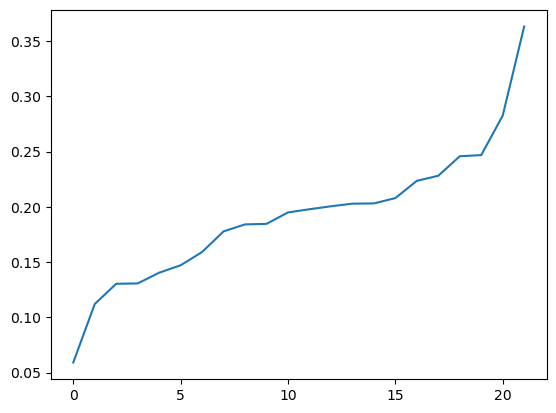

fit df.shape (179957, 39)


INFO:tensorflow:Assets written to: /tmp/tmpbepjb1z6/assets


INFO:tensorflow:Assets written to: /tmp/tmpbepjb1z6/assets
2022-11-09 13:56:15.384829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:15.384924: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:15.385128: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbepjb1z6
2022-11-09 13:56:15.387322: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:15.387364: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbepjb1z6
2022-11-09 13:56:15.394610: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:15.453610: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbepjb1z6
2022-11-09 13:56:15.468851: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx2kago6m/assets


INFO:tensorflow:Assets written to: /tmp/tmpx2kago6m/assets
2022-11-09 13:56:17.233018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:17.233110: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:17.233303: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx2kago6m
2022-11-09 13:56:17.235428: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:17.235477: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx2kago6m
2022-11-09 13:56:17.242689: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:17.302434: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx2kago6m
2022-11-09 13:56:17.317975: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9t1w5by5/assets


INFO:tensorflow:Assets written to: /tmp/tmp9t1w5by5/assets
2022-11-09 13:56:19.063069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:19.063148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:19.063346: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9t1w5by5
2022-11-09 13:56:19.065507: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:19.065549: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9t1w5by5
2022-11-09 13:56:19.072689: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:19.132342: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9t1w5by5
2022-11-09 13:56:19.148080: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_v3sxh83/assets


INFO:tensorflow:Assets written to: /tmp/tmp_v3sxh83/assets
2022-11-09 13:56:20.927145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:20.927215: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:20.927408: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_v3sxh83
2022-11-09 13:56:20.929518: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:20.929564: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_v3sxh83
2022-11-09 13:56:20.936636: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:20.995527: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_v3sxh83
2022-11-09 13:56:21.012079: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp982xvw4y/assets


INFO:tensorflow:Assets written to: /tmp/tmp982xvw4y/assets
2022-11-09 13:56:22.789204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:22.789295: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:22.789511: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp982xvw4y
2022-11-09 13:56:22.791637: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:22.791680: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp982xvw4y
2022-11-09 13:56:22.799163: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:22.860141: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp982xvw4y
2022-11-09 13:56:22.876560: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd2evqhn5/assets


INFO:tensorflow:Assets written to: /tmp/tmpd2evqhn5/assets
2022-11-09 13:56:24.682865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:24.682958: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:24.683151: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd2evqhn5
2022-11-09 13:56:24.685317: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:24.685362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd2evqhn5
2022-11-09 13:56:24.692549: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:24.751647: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd2evqhn5
2022-11-09 13:56:24.767066: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4_e39otx/assets


INFO:tensorflow:Assets written to: /tmp/tmp4_e39otx/assets
2022-11-09 13:56:26.579822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:26.579913: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:26.580128: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4_e39otx
2022-11-09 13:56:26.582259: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:26.582298: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4_e39otx
2022-11-09 13:56:26.589132: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:26.648699: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4_e39otx
2022-11-09 13:56:26.665001: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkmxbzd9e/assets


INFO:tensorflow:Assets written to: /tmp/tmpkmxbzd9e/assets
2022-11-09 13:56:28.459502: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:28.459601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:28.459797: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkmxbzd9e
2022-11-09 13:56:28.461993: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:28.462040: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkmxbzd9e
2022-11-09 13:56:28.469469: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:28.530557: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkmxbzd9e
2022-11-09 13:56:28.546897: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1kn2h77p/assets


INFO:tensorflow:Assets written to: /tmp/tmp1kn2h77p/assets
2022-11-09 13:56:31.851898: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:31.851987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:31.852186: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1kn2h77p
2022-11-09 13:56:31.855439: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:31.855493: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1kn2h77p
2022-11-09 13:56:31.865194: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:31.930970: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1kn2h77p
2022-11-09 13:56:31.949074: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1wjlwbs7/assets


INFO:tensorflow:Assets written to: /tmp/tmp1wjlwbs7/assets
2022-11-09 13:56:33.753848: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 13:56:33.753935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 13:56:33.754126: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1wjlwbs7
2022-11-09 13:56:33.756409: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 13:56:33.756453: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1wjlwbs7
2022-11-09 13:56:33.763968: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 13:56:33.825357: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1wjlwbs7
2022-11-09 13:56:33.841182: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

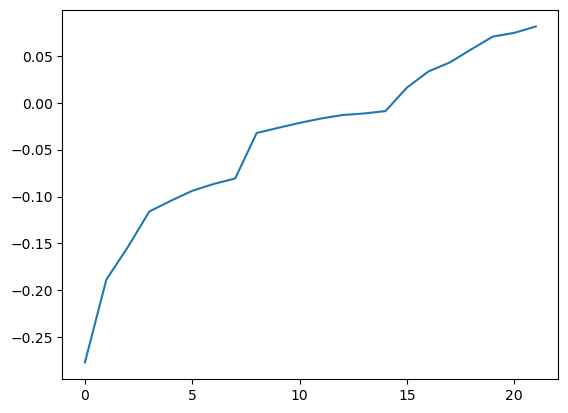

fit df.shape (179957, 39)


INFO:tensorflow:Assets written to: /tmp/tmpeu5majm7/assets


INFO:tensorflow:Assets written to: /tmp/tmpeu5majm7/assets
2022-11-09 14:02:26.202952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:26.203048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:26.203252: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeu5majm7
2022-11-09 14:02:26.205486: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:26.205532: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeu5majm7
2022-11-09 14:02:26.212888: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:26.273409: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeu5majm7
2022-11-09 14:02:26.289191: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplqc163sa/assets


INFO:tensorflow:Assets written to: /tmp/tmplqc163sa/assets
2022-11-09 14:02:28.096987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:28.097079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:28.097273: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplqc163sa
2022-11-09 14:02:28.099427: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:28.099473: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplqc163sa
2022-11-09 14:02:28.106654: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:28.166249: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplqc163sa
2022-11-09 14:02:28.181927: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp56aofxv6/assets


INFO:tensorflow:Assets written to: /tmp/tmp56aofxv6/assets
2022-11-09 14:02:29.981099: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:29.981184: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:29.981389: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp56aofxv6
2022-11-09 14:02:29.983524: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:29.983565: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp56aofxv6
2022-11-09 14:02:29.990673: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:30.051409: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp56aofxv6
2022-11-09 14:02:30.067035: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqkf2t3l4/assets


INFO:tensorflow:Assets written to: /tmp/tmpqkf2t3l4/assets
2022-11-09 14:02:31.849526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:31.849611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:31.849806: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqkf2t3l4
2022-11-09 14:02:31.851930: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:31.851973: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqkf2t3l4
2022-11-09 14:02:31.859027: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:31.919075: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqkf2t3l4
2022-11-09 14:02:31.934886: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5yhazhln/assets


INFO:tensorflow:Assets written to: /tmp/tmp5yhazhln/assets
2022-11-09 14:02:33.726050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:33.726137: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:33.726333: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5yhazhln
2022-11-09 14:02:33.728462: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:33.728502: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5yhazhln
2022-11-09 14:02:33.735699: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:33.795473: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5yhazhln
2022-11-09 14:02:33.811296: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjchbmbz5/assets


INFO:tensorflow:Assets written to: /tmp/tmpjchbmbz5/assets
2022-11-09 14:02:35.592908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:35.593004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:35.593201: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjchbmbz5
2022-11-09 14:02:35.595392: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:35.595438: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjchbmbz5
2022-11-09 14:02:35.602639: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:35.662191: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjchbmbz5
2022-11-09 14:02:35.677888: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc31plsms/assets


INFO:tensorflow:Assets written to: /tmp/tmpc31plsms/assets
2022-11-09 14:02:37.443846: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:37.443943: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:37.444148: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc31plsms
2022-11-09 14:02:37.446487: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:37.446541: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc31plsms
2022-11-09 14:02:37.453845: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:37.514259: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc31plsms
2022-11-09 14:02:37.529627: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5j1zwc7j/assets


INFO:tensorflow:Assets written to: /tmp/tmp5j1zwc7j/assets
2022-11-09 14:02:39.302409: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:39.302494: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:39.302699: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5j1zwc7j
2022-11-09 14:02:39.304822: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:39.304862: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5j1zwc7j
2022-11-09 14:02:39.311982: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:39.372523: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5j1zwc7j
2022-11-09 14:02:39.389309: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwf6qkzcd/assets


INFO:tensorflow:Assets written to: /tmp/tmpwf6qkzcd/assets
2022-11-09 14:02:41.171534: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:41.171623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:41.171828: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwf6qkzcd
2022-11-09 14:02:41.173952: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:41.173994: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwf6qkzcd
2022-11-09 14:02:41.180691: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:41.238217: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwf6qkzcd
2022-11-09 14:02:41.252750: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8_ocw48m/assets


INFO:tensorflow:Assets written to: /tmp/tmp8_ocw48m/assets
2022-11-09 14:02:43.018635: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:02:43.018730: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:02:43.018930: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8_ocw48m
2022-11-09 14:02:43.021120: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:02:43.021165: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8_ocw48m
2022-11-09 14:02:43.028452: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:02:43.089699: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8_ocw48m
2022-11-09 14:02:43.105706: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

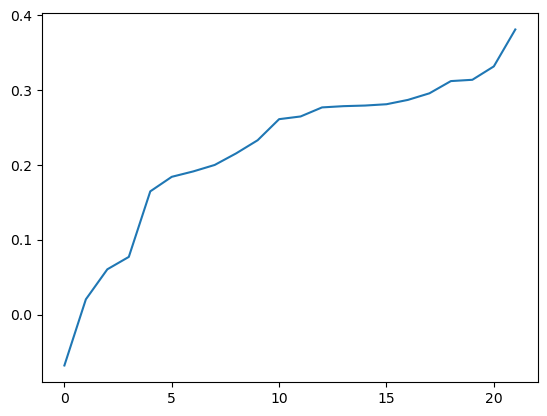

fit df.shape (180191, 39)


INFO:tensorflow:Assets written to: /tmp/tmpmo1usch2/assets


INFO:tensorflow:Assets written to: /tmp/tmpmo1usch2/assets
2022-11-09 14:13:28.868006: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:28.868101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:28.868301: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmo1usch2
2022-11-09 14:13:28.870471: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:28.870508: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmo1usch2
2022-11-09 14:13:28.877514: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:28.936126: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmo1usch2
2022-11-09 14:13:28.952674: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgmm20pih/assets


INFO:tensorflow:Assets written to: /tmp/tmpgmm20pih/assets
2022-11-09 14:13:30.722553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:30.722642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:30.722838: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgmm20pih
2022-11-09 14:13:30.724990: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:30.725032: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgmm20pih
2022-11-09 14:13:30.732219: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:30.791661: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgmm20pih
2022-11-09 14:13:30.807444: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxmq2sdsb/assets


INFO:tensorflow:Assets written to: /tmp/tmpxmq2sdsb/assets
2022-11-09 14:13:32.603672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:32.603762: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:32.603955: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxmq2sdsb
2022-11-09 14:13:32.606080: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:32.606122: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxmq2sdsb
2022-11-09 14:13:32.613220: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:32.673604: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxmq2sdsb
2022-11-09 14:13:32.688887: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq99mghg2/assets


INFO:tensorflow:Assets written to: /tmp/tmpq99mghg2/assets
2022-11-09 14:13:34.455720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:34.455813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:34.456008: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq99mghg2
2022-11-09 14:13:34.458226: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:34.458272: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq99mghg2
2022-11-09 14:13:34.465641: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:34.526583: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq99mghg2
2022-11-09 14:13:34.542442: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsw_1haw2/assets


INFO:tensorflow:Assets written to: /tmp/tmpsw_1haw2/assets
2022-11-09 14:13:36.311083: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:36.311166: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:36.311357: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsw_1haw2
2022-11-09 14:13:36.313550: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:36.313592: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsw_1haw2
2022-11-09 14:13:36.320607: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:36.379231: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsw_1haw2
2022-11-09 14:13:36.394546: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg6lm4xhv/assets


INFO:tensorflow:Assets written to: /tmp/tmpg6lm4xhv/assets
2022-11-09 14:13:38.180922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:38.181009: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:38.181204: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg6lm4xhv
2022-11-09 14:13:38.183353: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:38.183394: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg6lm4xhv
2022-11-09 14:13:38.190379: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:38.249039: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg6lm4xhv
2022-11-09 14:13:38.264529: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp__ptiwhd/assets


INFO:tensorflow:Assets written to: /tmp/tmp__ptiwhd/assets
2022-11-09 14:13:40.025776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:40.025867: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:40.026062: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp__ptiwhd
2022-11-09 14:13:40.028202: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:40.028246: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp__ptiwhd
2022-11-09 14:13:40.035421: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:40.094187: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp__ptiwhd
2022-11-09 14:13:40.109519: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp08f4a5ea/assets


INFO:tensorflow:Assets written to: /tmp/tmp08f4a5ea/assets
2022-11-09 14:13:41.864815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:41.864901: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:41.865094: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp08f4a5ea
2022-11-09 14:13:41.867219: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:41.867259: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp08f4a5ea
2022-11-09 14:13:41.874282: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:41.931691: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp08f4a5ea
2022-11-09 14:13:41.946517: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4asqxh9n/assets


INFO:tensorflow:Assets written to: /tmp/tmp4asqxh9n/assets
2022-11-09 14:13:43.727822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:43.727912: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:43.728107: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4asqxh9n
2022-11-09 14:13:43.730220: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:43.730261: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4asqxh9n
2022-11-09 14:13:43.737044: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:43.794096: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4asqxh9n
2022-11-09 14:13:43.808826: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoql346po/assets


INFO:tensorflow:Assets written to: /tmp/tmpoql346po/assets
2022-11-09 14:13:45.601102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 14:13:45.601197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 14:13:45.601401: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoql346po
2022-11-09 14:13:45.604170: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 14:13:45.604211: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoql346po
2022-11-09 14:13:45.623422: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 14:13:45.686031: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoql346po
2022-11-09 14:13:45.701270: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

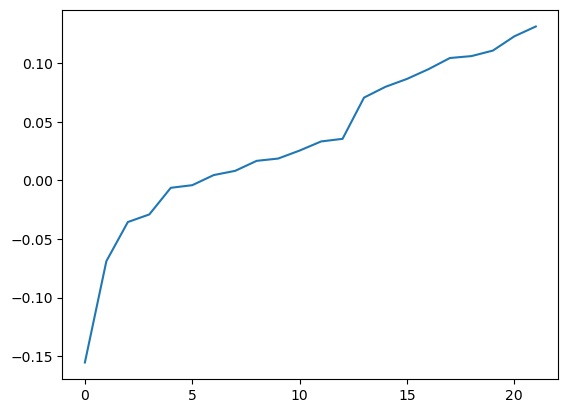

return without cost statistics
mean 0.0015619292137827253
std 0.009780936343965629
sharpe 0.15969117463343488
double sharpe 1.9560698930832017
max drawdown 0.20577395909303678
return with cost statistics
mean 0.00034221815203647
std 0.009801840720118677
sharpe 0.03491366181191389
double sharpe 0.1901204395571943
max drawdown 0.20589465163452306


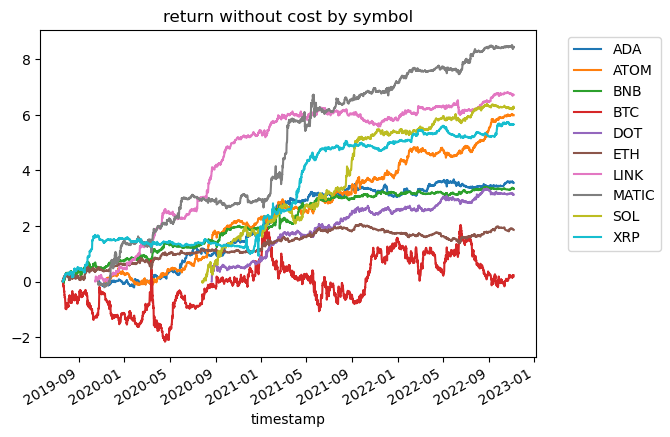

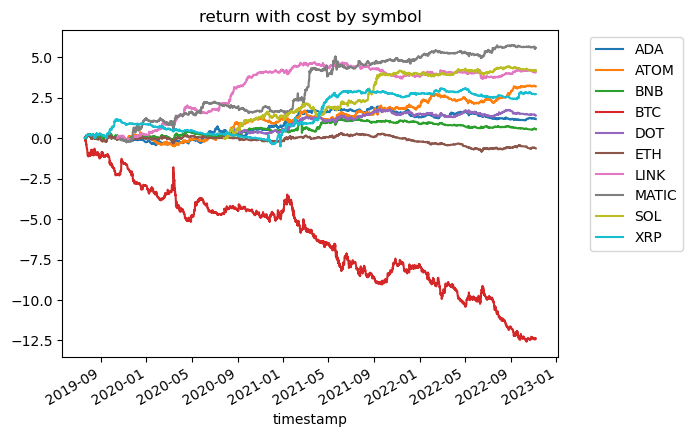

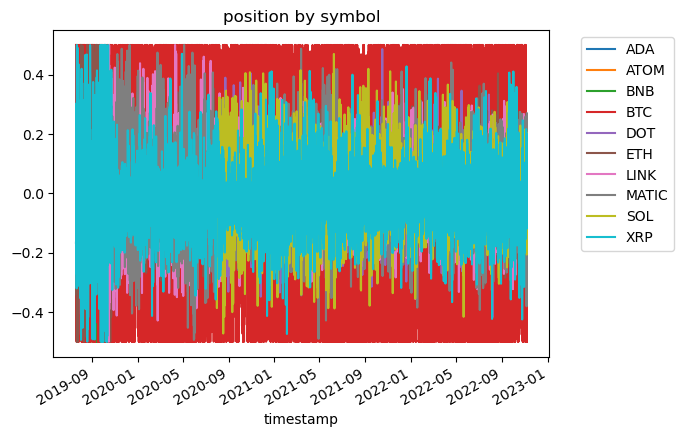

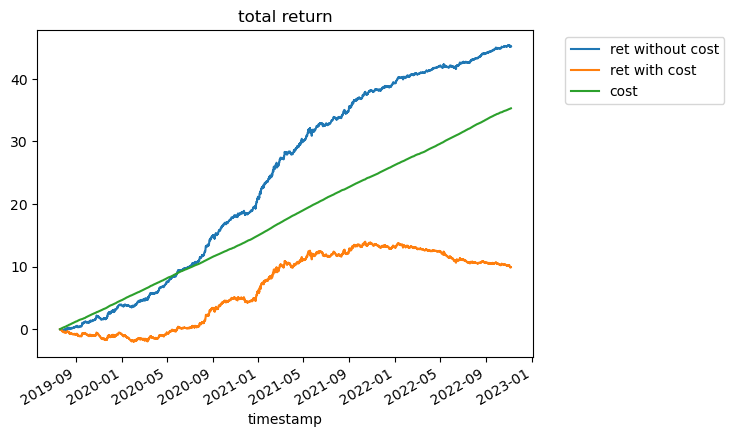

fit df.shape (232490, 39)


INFO:tensorflow:Assets written to: /tmp/tmp6f0_p6b4/assets


INFO:tensorflow:Assets written to: /tmp/tmp6f0_p6b4/assets
2022-11-09 15:10:23.037621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:23.037717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:23.038215: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6f0_p6b4
2022-11-09 15:10:23.040973: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:23.041045: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6f0_p6b4
2022-11-09 15:10:23.048363: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:23.107577: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6f0_p6b4
2022-11-09 15:10:23.122983: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0lokci7f/assets


INFO:tensorflow:Assets written to: /tmp/tmp0lokci7f/assets
2022-11-09 15:10:24.930585: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:24.930668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:24.930861: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0lokci7f
2022-11-09 15:10:24.933170: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:24.933209: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0lokci7f
2022-11-09 15:10:24.944231: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:25.005899: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0lokci7f
2022-11-09 15:10:25.021268: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfwabjj9h/assets


INFO:tensorflow:Assets written to: /tmp/tmpfwabjj9h/assets
2022-11-09 15:10:28.373064: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:28.373153: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:28.373363: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfwabjj9h
2022-11-09 15:10:28.378850: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:28.378904: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfwabjj9h
2022-11-09 15:10:28.405072: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:28.539233: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfwabjj9h
2022-11-09 15:10:28.582279: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgptngv0f/assets


INFO:tensorflow:Assets written to: /tmp/tmpgptngv0f/assets
2022-11-09 15:10:30.772663: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:30.772749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:30.772952: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgptngv0f
2022-11-09 15:10:30.777220: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:30.777270: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgptngv0f
2022-11-09 15:10:30.790800: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:30.863235: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgptngv0f
2022-11-09 15:10:30.885836: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm0064xw6/assets


INFO:tensorflow:Assets written to: /tmp/tmpm0064xw6/assets
2022-11-09 15:10:32.798274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:32.798365: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:32.798571: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm0064xw6
2022-11-09 15:10:32.801121: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:32.801161: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm0064xw6
2022-11-09 15:10:32.808482: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:32.868923: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm0064xw6
2022-11-09 15:10:32.885019: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp76p7flc8/assets


INFO:tensorflow:Assets written to: /tmp/tmp76p7flc8/assets
2022-11-09 15:10:34.673388: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:34.673491: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:34.673695: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp76p7flc8
2022-11-09 15:10:34.675814: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:34.675853: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp76p7flc8
2022-11-09 15:10:34.682948: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:34.741950: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp76p7flc8
2022-11-09 15:10:34.757208: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_n6m4rc0/assets


INFO:tensorflow:Assets written to: /tmp/tmp_n6m4rc0/assets
2022-11-09 15:10:36.536459: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:36.536555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:36.536768: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_n6m4rc0
2022-11-09 15:10:36.538967: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:36.539014: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_n6m4rc0
2022-11-09 15:10:36.546037: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:36.605815: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_n6m4rc0
2022-11-09 15:10:36.622226: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6960y1sw/assets


INFO:tensorflow:Assets written to: /tmp/tmp6960y1sw/assets
2022-11-09 15:10:38.373984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:38.374074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:38.374278: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6960y1sw
2022-11-09 15:10:38.376457: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:38.376499: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6960y1sw
2022-11-09 15:10:38.383753: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:38.445999: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6960y1sw
2022-11-09 15:10:38.461695: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu22egnxh/assets


INFO:tensorflow:Assets written to: /tmp/tmpu22egnxh/assets
2022-11-09 15:10:40.237923: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:40.238010: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:40.238210: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu22egnxh
2022-11-09 15:10:40.240342: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:40.240383: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu22egnxh
2022-11-09 15:10:40.247484: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:40.306436: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu22egnxh
2022-11-09 15:10:40.322126: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe3okidx6/assets


INFO:tensorflow:Assets written to: /tmp/tmpe3okidx6/assets
2022-11-09 15:10:42.132815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:42.132911: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:42.133124: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe3okidx6
2022-11-09 15:10:42.135359: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:42.135413: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe3okidx6
2022-11-09 15:10:42.142948: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:42.207005: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe3okidx6
2022-11-09 15:10:42.224045: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5aux864o/assets


INFO:tensorflow:Assets written to: /tmp/tmp5aux864o/assets
2022-11-09 15:10:44.027422: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:44.027522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:44.027721: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5aux864o
2022-11-09 15:10:44.029871: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:44.029911: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5aux864o
2022-11-09 15:10:44.037057: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:44.095982: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5aux864o
2022-11-09 15:10:44.111303: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdptknruy/assets


INFO:tensorflow:Assets written to: /tmp/tmpdptknruy/assets
2022-11-09 15:10:45.876985: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:45.877076: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:45.877272: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdptknruy
2022-11-09 15:10:45.879476: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:45.879525: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdptknruy
2022-11-09 15:10:45.886731: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:45.946467: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdptknruy
2022-11-09 15:10:45.962703: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9fezn15x/assets


INFO:tensorflow:Assets written to: /tmp/tmp9fezn15x/assets
2022-11-09 15:10:47.753630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:47.753718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:47.753913: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9fezn15x
2022-11-09 15:10:47.756044: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:47.756088: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9fezn15x
2022-11-09 15:10:47.763263: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:47.822908: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9fezn15x
2022-11-09 15:10:47.838675: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj9elrqg8/assets


INFO:tensorflow:Assets written to: /tmp/tmpj9elrqg8/assets
2022-11-09 15:10:49.617530: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:49.617614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:49.617809: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj9elrqg8
2022-11-09 15:10:49.619942: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:49.619984: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj9elrqg8
2022-11-09 15:10:49.627305: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:49.687086: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj9elrqg8
2022-11-09 15:10:49.703006: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxomcy5my/assets


INFO:tensorflow:Assets written to: /tmp/tmpxomcy5my/assets
2022-11-09 15:10:51.488945: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:51.489035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:51.489230: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxomcy5my
2022-11-09 15:10:51.491357: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:51.491402: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxomcy5my
2022-11-09 15:10:51.498363: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:51.557674: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxomcy5my
2022-11-09 15:10:51.574216: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqn4_1uh6/assets


INFO:tensorflow:Assets written to: /tmp/tmpqn4_1uh6/assets
2022-11-09 15:10:53.343957: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:53.344040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:53.344234: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqn4_1uh6
2022-11-09 15:10:53.346361: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:53.346399: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqn4_1uh6
2022-11-09 15:10:53.353345: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:53.413345: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqn4_1uh6
2022-11-09 15:10:53.428930: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpibdps361/assets


INFO:tensorflow:Assets written to: /tmp/tmpibdps361/assets
2022-11-09 15:10:58.155471: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:10:58.155568: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:10:58.155776: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpibdps361
2022-11-09 15:10:58.160543: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:10:58.160638: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpibdps361
2022-11-09 15:10:58.178102: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:10:58.259329: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpibdps361
2022-11-09 15:10:58.284502: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpei3jpc1r/assets


INFO:tensorflow:Assets written to: /tmp/tmpei3jpc1r/assets
2022-11-09 15:11:00.225149: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:00.225234: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:00.225486: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpei3jpc1r
2022-11-09 15:11:00.228560: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:00.228608: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpei3jpc1r
2022-11-09 15:11:00.239134: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:00.304604: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpei3jpc1r
2022-11-09 15:11:00.323966: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp909vmpj_/assets


INFO:tensorflow:Assets written to: /tmp/tmp909vmpj_/assets
2022-11-09 15:11:02.210551: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:02.210652: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:02.210852: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp909vmpj_
2022-11-09 15:11:02.213391: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:02.213484: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp909vmpj_
2022-11-09 15:11:02.221934: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:02.286550: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp909vmpj_
2022-11-09 15:11:02.303409: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4tbqta62/assets


INFO:tensorflow:Assets written to: /tmp/tmp4tbqta62/assets
2022-11-09 15:11:04.113364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:04.113473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:04.113677: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4tbqta62
2022-11-09 15:11:04.115923: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:04.115967: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4tbqta62
2022-11-09 15:11:04.123460: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:04.186083: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4tbqta62
2022-11-09 15:11:04.202664: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphun69ozt/assets


INFO:tensorflow:Assets written to: /tmp/tmphun69ozt/assets
2022-11-09 15:11:05.984990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:05.985077: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:05.985267: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphun69ozt
2022-11-09 15:11:05.987420: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:05.987465: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphun69ozt
2022-11-09 15:11:05.994629: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:06.054930: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphun69ozt
2022-11-09 15:11:06.072713: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpys4f237a/assets


INFO:tensorflow:Assets written to: /tmp/tmpys4f237a/assets
2022-11-09 15:11:07.860659: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:07.860748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:07.860944: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpys4f237a
2022-11-09 15:11:07.863154: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:07.863199: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpys4f237a
2022-11-09 15:11:07.870475: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:07.931340: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpys4f237a
2022-11-09 15:11:07.947483: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplnjic9xm/assets


INFO:tensorflow:Assets written to: /tmp/tmplnjic9xm/assets
2022-11-09 15:11:09.749996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:09.750086: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:09.750279: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplnjic9xm
2022-11-09 15:11:09.752439: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:09.752483: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplnjic9xm
2022-11-09 15:11:09.759735: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:09.821779: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplnjic9xm
2022-11-09 15:11:09.837998: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt5zll58_/assets


INFO:tensorflow:Assets written to: /tmp/tmpt5zll58_/assets
2022-11-09 15:11:11.633754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:11.633845: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:11.634038: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt5zll58_
2022-11-09 15:11:11.636193: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:11.636236: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt5zll58_
2022-11-09 15:11:11.643442: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:11.707604: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt5zll58_
2022-11-09 15:11:11.723899: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0v_k7bvd/assets


INFO:tensorflow:Assets written to: /tmp/tmp0v_k7bvd/assets
2022-11-09 15:11:13.523191: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:13.523287: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:13.523488: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0v_k7bvd
2022-11-09 15:11:13.525710: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:13.525756: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0v_k7bvd
2022-11-09 15:11:13.533164: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:13.594915: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0v_k7bvd
2022-11-09 15:11:13.611492: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3_gcmozq/assets


INFO:tensorflow:Assets written to: /tmp/tmp3_gcmozq/assets
2022-11-09 15:11:15.407685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:15.407777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:15.407991: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3_gcmozq
2022-11-09 15:11:15.410237: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:15.410290: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3_gcmozq
2022-11-09 15:11:15.417550: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:15.478239: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3_gcmozq
2022-11-09 15:11:15.493956: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprbxciwlf/assets


INFO:tensorflow:Assets written to: /tmp/tmprbxciwlf/assets
2022-11-09 15:11:17.269696: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:17.269784: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:17.269977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprbxciwlf
2022-11-09 15:11:17.272086: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:17.272126: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprbxciwlf
2022-11-09 15:11:17.279033: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:17.337889: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprbxciwlf
2022-11-09 15:11:17.353614: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2uds8upl/assets


INFO:tensorflow:Assets written to: /tmp/tmp2uds8upl/assets
2022-11-09 15:11:19.152928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:19.153003: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:19.153202: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2uds8upl
2022-11-09 15:11:19.155335: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:19.155375: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2uds8upl
2022-11-09 15:11:19.162639: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:19.222039: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2uds8upl
2022-11-09 15:11:19.237781: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpodhzhkqw/assets


INFO:tensorflow:Assets written to: /tmp/tmpodhzhkqw/assets
2022-11-09 15:11:23.487638: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:23.487726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:23.487954: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpodhzhkqw
2022-11-09 15:11:23.494130: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:23.494187: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpodhzhkqw
2022-11-09 15:11:23.517908: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:23.629231: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpodhzhkqw
2022-11-09 15:11:23.665664: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpapzhr3_0/assets


INFO:tensorflow:Assets written to: /tmp/tmpapzhr3_0/assets
2022-11-09 15:11:25.825862: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:25.825951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:25.826155: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpapzhr3_0
2022-11-09 15:11:25.830442: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:25.830499: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpapzhr3_0
2022-11-09 15:11:25.844278: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:25.919154: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpapzhr3_0
2022-11-09 15:11:25.941845: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvobrgtd0/assets


INFO:tensorflow:Assets written to: /tmp/tmpvobrgtd0/assets
2022-11-09 15:11:27.826974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:27.827058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:27.827251: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvobrgtd0
2022-11-09 15:11:27.829900: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:27.829945: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvobrgtd0
2022-11-09 15:11:27.838916: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:27.903190: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvobrgtd0
2022-11-09 15:11:27.920785: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvb1hlxbu/assets


INFO:tensorflow:Assets written to: /tmp/tmpvb1hlxbu/assets
2022-11-09 15:11:29.742376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:29.742462: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:29.742662: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvb1hlxbu
2022-11-09 15:11:29.744962: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:29.745002: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvb1hlxbu
2022-11-09 15:11:29.752790: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:29.815485: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvb1hlxbu
2022-11-09 15:11:29.831911: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2rait1ix/assets


INFO:tensorflow:Assets written to: /tmp/tmp2rait1ix/assets
2022-11-09 15:11:31.626700: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:31.626790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:31.626987: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2rait1ix
2022-11-09 15:11:31.629211: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:31.629255: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2rait1ix
2022-11-09 15:11:31.636731: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:31.699955: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2rait1ix
2022-11-09 15:11:31.716677: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpifda_vkx/assets


INFO:tensorflow:Assets written to: /tmp/tmpifda_vkx/assets
2022-11-09 15:11:33.517398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:33.517497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:33.517690: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpifda_vkx
2022-11-09 15:11:33.519860: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:33.519904: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpifda_vkx
2022-11-09 15:11:33.527251: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:33.588311: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpifda_vkx
2022-11-09 15:11:33.604234: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw08tyzhu/assets


INFO:tensorflow:Assets written to: /tmp/tmpw08tyzhu/assets
2022-11-09 15:11:35.371028: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:35.371118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:35.371314: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw08tyzhu
2022-11-09 15:11:35.373465: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:35.373512: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw08tyzhu
2022-11-09 15:11:35.380696: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:35.441267: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw08tyzhu
2022-11-09 15:11:35.457259: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3j8p7z3i/assets


INFO:tensorflow:Assets written to: /tmp/tmp3j8p7z3i/assets
2022-11-09 15:11:37.222393: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:37.222478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:37.222681: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3j8p7z3i
2022-11-09 15:11:37.224845: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:37.224884: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3j8p7z3i
2022-11-09 15:11:37.231839: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:37.291976: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3j8p7z3i
2022-11-09 15:11:37.307357: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdk2pgo7n/assets


INFO:tensorflow:Assets written to: /tmp/tmpdk2pgo7n/assets
2022-11-09 15:11:39.053149: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:39.053239: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:39.053450: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdk2pgo7n
2022-11-09 15:11:39.055624: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:39.055669: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdk2pgo7n
2022-11-09 15:11:39.062880: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:39.121865: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdk2pgo7n
2022-11-09 15:11:39.137459: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpex055w5q/assets


INFO:tensorflow:Assets written to: /tmp/tmpex055w5q/assets
2022-11-09 15:11:40.922111: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:40.922192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:40.922394: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpex055w5q
2022-11-09 15:11:40.924484: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:40.924523: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpex055w5q
2022-11-09 15:11:40.931479: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:40.991787: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpex055w5q
2022-11-09 15:11:41.008081: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9dzw4me7/assets


INFO:tensorflow:Assets written to: /tmp/tmp9dzw4me7/assets
2022-11-09 15:11:42.769288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:42.769378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:42.769595: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9dzw4me7
2022-11-09 15:11:42.771706: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:42.771745: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9dzw4me7
2022-11-09 15:11:42.778784: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:42.838054: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9dzw4me7
2022-11-09 15:11:42.853345: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkp_abnda/assets


INFO:tensorflow:Assets written to: /tmp/tmpkp_abnda/assets
2022-11-09 15:11:47.061523: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:47.061622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:47.061845: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkp_abnda
2022-11-09 15:11:47.067294: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:47.067359: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkp_abnda
2022-11-09 15:11:47.087427: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:47.200084: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkp_abnda
2022-11-09 15:11:47.233671: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm639y8mo/assets


INFO:tensorflow:Assets written to: /tmp/tmpm639y8mo/assets
2022-11-09 15:11:49.325876: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:49.325961: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:49.326174: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm639y8mo
2022-11-09 15:11:49.330084: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:49.330135: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm639y8mo
2022-11-09 15:11:49.342461: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:49.413007: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm639y8mo
2022-11-09 15:11:49.434390: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_4_xz3e4/assets


INFO:tensorflow:Assets written to: /tmp/tmp_4_xz3e4/assets
2022-11-09 15:11:51.292731: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:51.292811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:51.293006: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_4_xz3e4
2022-11-09 15:11:51.295671: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:51.295716: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_4_xz3e4
2022-11-09 15:11:51.304454: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:51.370577: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_4_xz3e4
2022-11-09 15:11:51.388290: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm0_aupha/assets


INFO:tensorflow:Assets written to: /tmp/tmpm0_aupha/assets
2022-11-09 15:11:53.195069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:53.195164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:53.195381: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm0_aupha
2022-11-09 15:11:53.197854: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:53.197903: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm0_aupha
2022-11-09 15:11:53.206066: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:53.268761: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm0_aupha
2022-11-09 15:11:53.285066: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5rlp7us2/assets


INFO:tensorflow:Assets written to: /tmp/tmp5rlp7us2/assets
2022-11-09 15:11:55.073455: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:55.073559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:55.073767: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5rlp7us2
2022-11-09 15:11:55.075992: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:55.076035: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5rlp7us2
2022-11-09 15:11:55.083548: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:55.145829: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5rlp7us2
2022-11-09 15:11:55.162061: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0_x5_xgz/assets


INFO:tensorflow:Assets written to: /tmp/tmp0_x5_xgz/assets
2022-11-09 15:11:56.952875: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:56.952963: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:56.953164: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0_x5_xgz
2022-11-09 15:11:56.955367: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:56.955411: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0_x5_xgz
2022-11-09 15:11:56.962788: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:57.025107: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0_x5_xgz
2022-11-09 15:11:57.041789: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmh6c95hv/assets


INFO:tensorflow:Assets written to: /tmp/tmpmh6c95hv/assets
2022-11-09 15:11:58.817080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:11:58.817170: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:11:58.817364: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmh6c95hv
2022-11-09 15:11:58.819526: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:11:58.819567: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmh6c95hv
2022-11-09 15:11:58.826860: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:11:58.886928: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmh6c95hv
2022-11-09 15:11:58.902499: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvk0oxwjo/assets


INFO:tensorflow:Assets written to: /tmp/tmpvk0oxwjo/assets
2022-11-09 15:12:00.652741: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:00.652831: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:00.653024: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvk0oxwjo
2022-11-09 15:12:00.655186: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:00.655226: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvk0oxwjo
2022-11-09 15:12:00.662448: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:00.723012: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvk0oxwjo
2022-11-09 15:12:00.738467: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqfe18hij/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfe18hij/assets
2022-11-09 15:12:02.713403: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:02.713510: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:02.713715: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqfe18hij
2022-11-09 15:12:02.715876: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:02.715925: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqfe18hij
2022-11-09 15:12:02.723406: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:02.786146: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqfe18hij
2022-11-09 15:12:02.802513: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp807789cf/assets


INFO:tensorflow:Assets written to: /tmp/tmp807789cf/assets
2022-11-09 15:12:06.771505: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:06.771605: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:06.771814: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp807789cf
2022-11-09 15:12:06.776783: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:06.776897: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp807789cf
2022-11-09 15:12:06.795519: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:06.893325: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp807789cf
2022-11-09 15:12:06.922871: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpddnjxfgf/assets


INFO:tensorflow:Assets written to: /tmp/tmpddnjxfgf/assets
2022-11-09 15:12:08.982061: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:08.982150: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:08.982349: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpddnjxfgf
2022-11-09 15:12:08.986149: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:08.986198: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpddnjxfgf
2022-11-09 15:12:08.998769: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:09.070235: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpddnjxfgf
2022-11-09 15:12:09.091068: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkbjjqrhd/assets


INFO:tensorflow:Assets written to: /tmp/tmpkbjjqrhd/assets
2022-11-09 15:12:10.955464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:10.955553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:10.955748: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkbjjqrhd
2022-11-09 15:12:10.958396: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:10.958455: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkbjjqrhd
2022-11-09 15:12:10.967342: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:11.032053: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkbjjqrhd
2022-11-09 15:12:11.050217: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxeqco8v6/assets


INFO:tensorflow:Assets written to: /tmp/tmpxeqco8v6/assets
2022-11-09 15:12:12.884589: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:12.884683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:12.884876: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxeqco8v6
2022-11-09 15:12:12.887302: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:12.887352: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxeqco8v6
2022-11-09 15:12:12.895600: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:12.959510: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxeqco8v6
2022-11-09 15:12:12.976669: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa_cs8y_c/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_cs8y_c/assets
2022-11-09 15:12:14.793885: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:14.793969: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:14.794163: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa_cs8y_c
2022-11-09 15:12:14.796407: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:14.796449: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa_cs8y_c
2022-11-09 15:12:14.803961: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:14.865733: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa_cs8y_c
2022-11-09 15:12:14.881644: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjyoaa7c3/assets


INFO:tensorflow:Assets written to: /tmp/tmpjyoaa7c3/assets
2022-11-09 15:12:16.702600: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:16.702686: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:16.702879: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjyoaa7c3
2022-11-09 15:12:16.705108: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:16.705156: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjyoaa7c3
2022-11-09 15:12:16.712485: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:16.774368: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjyoaa7c3
2022-11-09 15:12:16.790311: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0_iqvib6/assets


INFO:tensorflow:Assets written to: /tmp/tmp0_iqvib6/assets
2022-11-09 15:12:18.582303: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:18.582400: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:18.582593: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0_iqvib6
2022-11-09 15:12:18.584743: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:18.584786: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0_iqvib6
2022-11-09 15:12:18.592087: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:18.654102: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0_iqvib6
2022-11-09 15:12:18.670296: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjp3vozc4/assets


INFO:tensorflow:Assets written to: /tmp/tmpjp3vozc4/assets
2022-11-09 15:12:20.436222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:20.436312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:20.436508: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjp3vozc4
2022-11-09 15:12:20.438681: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:20.438724: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjp3vozc4
2022-11-09 15:12:20.445929: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:20.507279: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjp3vozc4
2022-11-09 15:12:20.523057: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpksgajvnf/assets


INFO:tensorflow:Assets written to: /tmp/tmpksgajvnf/assets
2022-11-09 15:12:24.223413: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:24.223503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:24.223707: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpksgajvnf
2022-11-09 15:12:24.228657: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:24.228774: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpksgajvnf
2022-11-09 15:12:24.248545: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:24.351864: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpksgajvnf
2022-11-09 15:12:24.385818: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn3b0whgd/assets


INFO:tensorflow:Assets written to: /tmp/tmpn3b0whgd/assets
2022-11-09 15:12:26.540435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:26.540537: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:26.540749: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn3b0whgd
2022-11-09 15:12:26.545197: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:26.545253: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn3b0whgd
2022-11-09 15:12:26.559657: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:26.634980: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn3b0whgd
2022-11-09 15:12:26.658083: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphmfbnyza/assets


INFO:tensorflow:Assets written to: /tmp/tmphmfbnyza/assets
2022-11-09 15:12:28.554355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:28.554449: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:28.554658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphmfbnyza
2022-11-09 15:12:28.557665: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:28.557714: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphmfbnyza
2022-11-09 15:12:28.567827: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:28.635858: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphmfbnyza
2022-11-09 15:12:28.654329: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd86l5ke4/assets


INFO:tensorflow:Assets written to: /tmp/tmpd86l5ke4/assets
2022-11-09 15:12:30.491951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:30.492040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:30.492232: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd86l5ke4
2022-11-09 15:12:30.494755: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:30.494803: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd86l5ke4
2022-11-09 15:12:30.503354: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:30.568545: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd86l5ke4
2022-11-09 15:12:30.587406: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpurdo8ez9/assets


INFO:tensorflow:Assets written to: /tmp/tmpurdo8ez9/assets
2022-11-09 15:12:32.426284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:32.426375: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:32.426585: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpurdo8ez9
2022-11-09 15:12:32.428898: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:32.428940: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpurdo8ez9
2022-11-09 15:12:32.436731: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:32.500302: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpurdo8ez9
2022-11-09 15:12:32.518442: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkmw_vnfn/assets


INFO:tensorflow:Assets written to: /tmp/tmpkmw_vnfn/assets
2022-11-09 15:12:34.321360: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:34.321453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:34.321657: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkmw_vnfn
2022-11-09 15:12:34.323831: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:34.323873: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkmw_vnfn
2022-11-09 15:12:34.331353: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:34.394743: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkmw_vnfn
2022-11-09 15:12:34.411399: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfjiw95gy/assets


INFO:tensorflow:Assets written to: /tmp/tmpfjiw95gy/assets
2022-11-09 15:12:37.611908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:37.611999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:37.612207: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfjiw95gy
2022-11-09 15:12:37.618175: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:37.618235: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfjiw95gy
2022-11-09 15:12:37.645709: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:37.797052: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfjiw95gy
2022-11-09 15:12:37.844875: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3o8i2ahf/assets


INFO:tensorflow:Assets written to: /tmp/tmp3o8i2ahf/assets
2022-11-09 15:12:40.182075: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:40.182163: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:40.182371: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3o8i2ahf
2022-11-09 15:12:40.187402: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:40.187542: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3o8i2ahf
2022-11-09 15:12:40.207142: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:40.311852: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3o8i2ahf
2022-11-09 15:12:40.343953: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkq50piq7/assets


INFO:tensorflow:Assets written to: /tmp/tmpkq50piq7/assets
2022-11-09 15:12:42.436349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:42.436442: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:42.436642: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkq50piq7
2022-11-09 15:12:42.440609: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:42.440663: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkq50piq7
2022-11-09 15:12:42.453490: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:42.523967: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkq50piq7
2022-11-09 15:12:42.544417: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpshvi7q09/assets


INFO:tensorflow:Assets written to: /tmp/tmpshvi7q09/assets
2022-11-09 15:12:44.420528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:44.420626: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:44.420828: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpshvi7q09
2022-11-09 15:12:44.423799: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:44.423846: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpshvi7q09
2022-11-09 15:12:44.433785: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:44.500785: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpshvi7q09
2022-11-09 15:12:44.519870: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd0lyzyi3/assets


INFO:tensorflow:Assets written to: /tmp/tmpd0lyzyi3/assets
2022-11-09 15:12:46.348250: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:46.348341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:46.348535: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd0lyzyi3
2022-11-09 15:12:46.351040: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:46.351095: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd0lyzyi3
2022-11-09 15:12:46.359468: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:46.424994: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd0lyzyi3
2022-11-09 15:12:46.442559: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3ndz6ljr/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ndz6ljr/assets
2022-11-09 15:12:48.302210: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:48.302307: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:48.302526: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3ndz6ljr
2022-11-09 15:12:48.304892: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:48.304941: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3ndz6ljr
2022-11-09 15:12:48.313549: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:48.378001: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3ndz6ljr
2022-11-09 15:12:48.394838: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvyef_pdk/assets


INFO:tensorflow:Assets written to: /tmp/tmpvyef_pdk/assets
2022-11-09 15:12:51.536848: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:51.536935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:51.537144: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvyef_pdk
2022-11-09 15:12:51.543234: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:51.543293: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvyef_pdk
2022-11-09 15:12:51.570382: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:51.714094: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvyef_pdk
2022-11-09 15:12:51.760099: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpezo5lu3t/assets


INFO:tensorflow:Assets written to: /tmp/tmpezo5lu3t/assets
2022-11-09 15:12:54.072947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:54.073038: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:54.073262: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpezo5lu3t
2022-11-09 15:12:54.078274: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:54.078330: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpezo5lu3t
2022-11-09 15:12:54.098228: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:54.205289: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpezo5lu3t
2022-11-09 15:12:54.236071: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph1akgve3/assets


INFO:tensorflow:Assets written to: /tmp/tmph1akgve3/assets
2022-11-09 15:12:56.364128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:56.364217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:56.364420: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph1akgve3
2022-11-09 15:12:56.368656: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:56.368710: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph1akgve3
2022-11-09 15:12:56.382245: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:56.457645: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph1akgve3
2022-11-09 15:12:56.479822: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp99fn0jz0/assets


INFO:tensorflow:Assets written to: /tmp/tmp99fn0jz0/assets
2022-11-09 15:12:58.359569: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:12:58.359658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:12:58.359856: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp99fn0jz0
2022-11-09 15:12:58.362811: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:12:58.362865: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp99fn0jz0
2022-11-09 15:12:58.372385: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:12:58.440308: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp99fn0jz0
2022-11-09 15:12:58.459501: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe7497xaf/assets


INFO:tensorflow:Assets written to: /tmp/tmpe7497xaf/assets
2022-11-09 15:13:00.298864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:00.298955: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:00.299152: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe7497xaf
2022-11-09 15:13:00.301682: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:00.301730: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe7497xaf
2022-11-09 15:13:00.310065: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:00.375609: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe7497xaf
2022-11-09 15:13:00.393006: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsa35u0y5/assets


INFO:tensorflow:Assets written to: /tmp/tmpsa35u0y5/assets
2022-11-09 15:13:02.276015: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:02.276107: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:02.276308: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsa35u0y5
2022-11-09 15:13:02.278783: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:02.278834: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsa35u0y5
2022-11-09 15:13:02.286719: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:02.350290: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsa35u0y5
2022-11-09 15:13:02.366763: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9dfui6ko/assets


INFO:tensorflow:Assets written to: /tmp/tmp9dfui6ko/assets
2022-11-09 15:13:05.662569: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:05.662659: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:05.662864: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9dfui6ko
2022-11-09 15:13:05.668188: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:05.668339: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9dfui6ko
2022-11-09 15:13:05.689310: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:05.797544: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9dfui6ko
2022-11-09 15:13:05.831709: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbry2n5km/assets


INFO:tensorflow:Assets written to: /tmp/tmpbry2n5km/assets
2022-11-09 15:13:07.972110: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:07.972202: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:07.972430: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbry2n5km
2022-11-09 15:13:07.977035: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:07.977095: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbry2n5km
2022-11-09 15:13:07.993465: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:08.073591: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbry2n5km
2022-11-09 15:13:08.098393: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb2z9ztsk/assets


INFO:tensorflow:Assets written to: /tmp/tmpb2z9ztsk/assets
2022-11-09 15:13:09.994778: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:09.994870: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:09.995067: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb2z9ztsk
2022-11-09 15:13:09.998133: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:09.998182: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb2z9ztsk
2022-11-09 15:13:10.008365: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:10.076836: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb2z9ztsk
2022-11-09 15:13:10.095776: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj6zrvrju/assets


INFO:tensorflow:Assets written to: /tmp/tmpj6zrvrju/assets
2022-11-09 15:13:11.947686: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:11.947774: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:11.947976: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj6zrvrju
2022-11-09 15:13:11.950492: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:11.950540: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj6zrvrju
2022-11-09 15:13:11.959151: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:12.025614: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj6zrvrju
2022-11-09 15:13:12.044257: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvik_f34x/assets


INFO:tensorflow:Assets written to: /tmp/tmpvik_f34x/assets
2022-11-09 15:13:14.897402: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:14.897512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:14.897727: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvik_f34x
2022-11-09 15:13:14.903847: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:14.903907: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvik_f34x
2022-11-09 15:13:14.928279: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:15.080972: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvik_f34x
2022-11-09 15:13:15.126178: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp675h0dx4/assets


INFO:tensorflow:Assets written to: /tmp/tmp675h0dx4/assets
2022-11-09 15:13:17.404921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 15:13:17.405005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 15:13:17.405209: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp675h0dx4
2022-11-09 15:13:17.410364: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 15:13:17.410427: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp675h0dx4
2022-11-09 15:13:17.430342: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 15:13:17.542615: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp675h0dx4
2022-11-09 15:13:17.575974: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [11]:
print(tf.keras.backend.floatx())

# df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon4_price_type_none.pkl')
# df = df.iloc[-10000:]

df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-07 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# sol_timestamps = df.loc[df.index.get_level_values('symbol') == 'SOL'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]
# df = df.loc[df.index.get_level_values('timestamp').isin(sol_timestamps)]

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# # cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221028_btc_one_cnn_h8.xz', 'wb') as f:
    f.write(data)

expt

- [20221028_btc_one_cnn_h8/20221109_222521.ipynb](20221028_btc_one_cnn_h8/20221109_222521.ipynb) without hedge (baseline)
- 

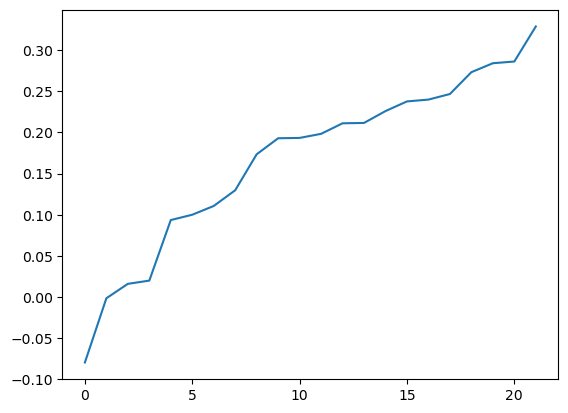

timestamp                  symbol
2022-09-10 12:00:00+00:00  ADA      -0.055556
                           ATOM     -0.055556
                           BNB      -0.055556
                           BTC       0.500000
                           DOT      -0.055556
                                       ...   
2022-11-09 12:00:00+00:00  ETH       0.087145
                           LINK      0.063686
                           MATIC     0.064809
                           SOL       0.130162
                           XRP       0.079760
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


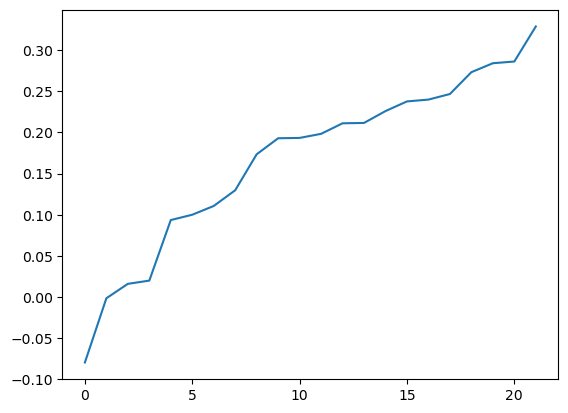

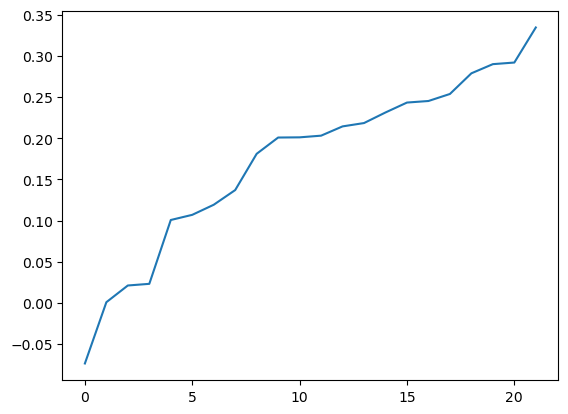

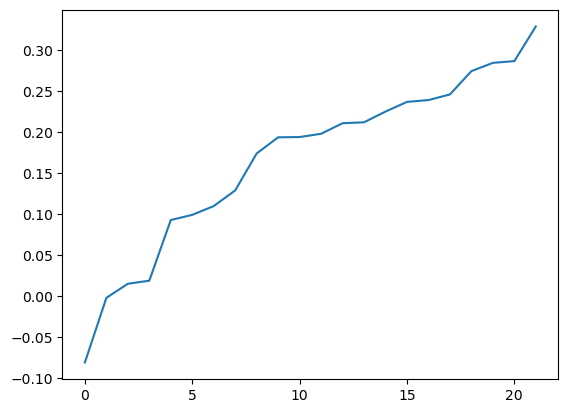

position1  position2  position3
timestamp                 symbol                                 
2022-09-10 13:00:00+00:00 ADA     -0.055556  -0.055556  -0.055556
                          ATOM    -0.055556  -0.055556  -0.055556
                          BNB     -0.055556  -0.055556  -0.055556
                          BTC      0.500000   0.500000   0.500000
                          DOT     -0.055556  -0.055556  -0.055556
...                                     ...        ...        ...
2022-11-09 11:00:00+00:00 ETH      0.097333   0.097333   0.097333
                          LINK     0.066277   0.066277   0.066277
                          MATIC    0.069993   0.069993   0.069993
                          SOL      0.111683   0.111683   0.111683
                          XRP      0.087110   0.087110   0.087110

[14390 rows x 3 columns]

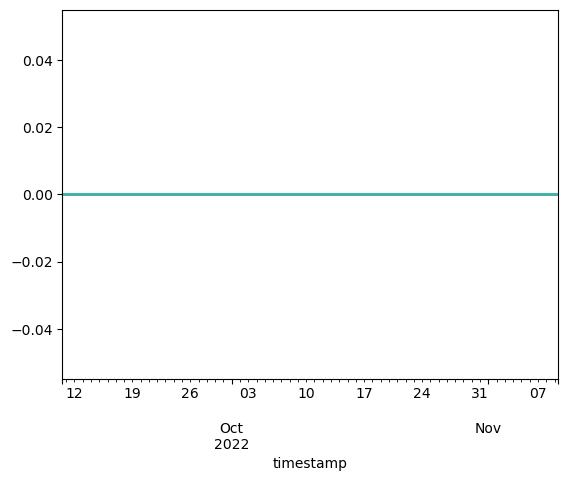

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


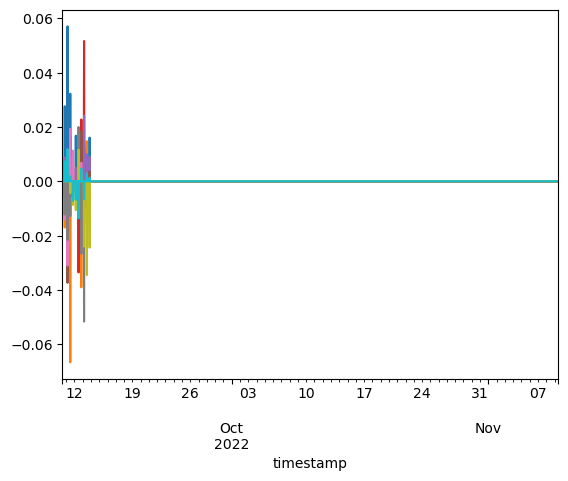

In [12]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221028_btc_one_cnn_h8.xz')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()